<h1>Open haloscope</h1>

<h4>Imports</h4>

In [21]:
import sys, os
import time

import numpy as np
from scipy.signal import periodogram, welch

import matplotlib.pyplot as plt
# plot options
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size=21)

<h3>Loading haloscope libraries</h3>

In [2]:
import lib.open_haloscope.experiment as experiment
import lib.open_haloscope.particles as particles

from lib.open_haloscope.utils import OHUtils

In [3]:
haloscope_name = 'kakapo_haloscope'
haloscope_json = OHUtils.load_experiment_json(haloscope_name)

H = experiment.FermionicHaloscope(haloscope_json)

In [4]:
from lib.red.redpitaya_qcodes import Redpitaya
red = Redpitaya('redpitaya', address=H.experiment_parameters['redpitaya_eth0_ip'])

Connected to: REDPITAYA INSTR2020 (serial:0, firmware:01-02) in 0.42s


<h3>Initialise and characterise the experiment</h3>

In [5]:
H.initialise_haloscope([red], decimation=8)

Loading instrumentation
  redpitaya added to the experiment

Setup the radiofrequency lines
 input gain set to LV
 trigger level = 0.0 V, decimation = 8
 resulting sampling frequency = 15.625 MHz
 buffer length = 16384 samples, i.e. 0.001048576 s
 output generators triggered, phase aligned and turned off

Starting UART communication
 testing sensors
 temperature = 298.90999999999997 K
 pressure = 1.1394600000000001 bar
 magnetic field = 2.36328125 V
 photoresistance = 0.029296875 V
 acceleration = (0.16, 0.0, 10.36) m/s^2

Configuring data storage
 data are stored in C:\Users\nicol\Progetti\Open Haloscope\data\runs\2023-06-07
 logs are stored in C:\Users\nicol\Progetti\Open Haloscope\data\logs\2023-06-07
 QCodes station, QCodes database and logfiles configured

Haloscope initialised. Good luck, dark matter hunter.


In [ ]:
H.characterise(frequency_points=2001, 
               averages=20, 
               monitoring_time=500, 
               plot=True)

In [ ]:
H.experiment_parameters

In [ ]:
H.update_json_file(haloscope_json, H.experiment_parameters)

<h3>Haloscope operation</h3>
Before running this part, check that the inputs of the redpitaya are switched to HV, since the input signal is going to be large, and will otherwise saturate the ADC.

In [ ]:
amplitude_gen_1 = 1 # volt
amplitude_gen_2 = 1 # volt

H.prepare_for_operation(a1=amplitude_gen_1, a2=amplitude_gen_2)

In [ ]:
run_time = 10000 # seconds
data_saver_periodicity = 10 # seconds

H.run(run_time, data_saver_periodicity)

<h3>Run analysis</h3>

In [6]:
f1, b1 = H.analyse_run("RUN_5", 1000)

Loading data
 loading data from C:\Users\nicol\Progetti\Open Haloscope\data\runs\2023-06-05\RUN_5_experiment_data.db
 RUN_5 data loaded

Interferometric down-conversion
 north arm frequency 5.454690349638967 MHz, east arm frequency 5.630663245536586 MHz
 phase_noise_rejection mode selected
 down-conversion frequency set to 5.542676797587776 MHz

Analysis and averaging
 in progress


1002it [01:27, 11.40it/s]                                                                                              


 averaging completed


In [7]:
f2, b2 = H.analyse_run("RUN_6", 1000)

Loading data
 loading data from C:\Users\nicol\Progetti\Open Haloscope\data\runs\2023-06-06\RUN_6_experiment_data.db
 RUN_6 data loaded

Interferometric down-conversion
 north arm frequency 5.454690349638967 MHz, east arm frequency 5.630663245536586 MHz
 phase_noise_rejection mode selected
 down-conversion frequency set to 5.542676797587776 MHz

Analysis and averaging
 in progress


1002it [01:28, 11.34it/s]                                                                                              


 averaging completed


In [8]:
f, sigma = H.calculate_residuals_upper_limit(f1, b1, b2)

<h3>Physics</h3>

In [9]:
ax = particles.DMAxion()
ax.print_axion_parameters()

Local dark matter density: 0.4 GeV/cm3
Relative speed of the dark matter wind: 0.001c = 299792.458 m/s
DFSZ axion coupling: 8.943e-11/mass, with upper limit 0.3 and lower limit 2e-05


In [10]:
ma_limit, gp_limit = ax.exclusion_plot(f, sigma)

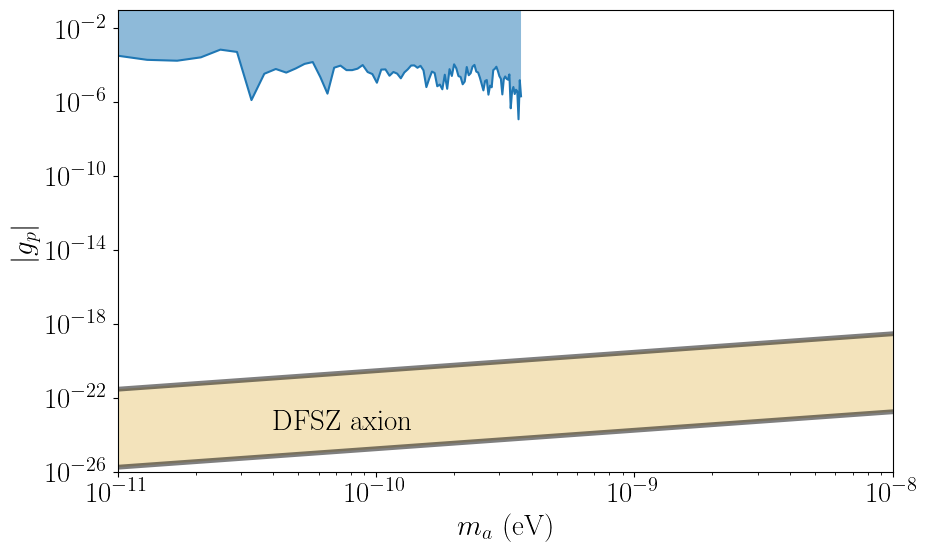

In [22]:
plt.figure(figsize=(10,6))

mass_start = 1e-11
mass_stop = 1e-8
mass_points = 10001
m_range = np.logspace(np.log10(mass_start), np.log10(mass_stop), mass_points)

ax.plot_DFSZ_axion(m_range)

# and finally the upper limit
plt.fill_between(ma_limit, gp_limit, 1, alpha=0.5)
plt.plot(ma_limit, gp_limit)


plt.xlim(mass_start, mass_stop)
plt.ylim(1e-26, 1e-1)

plt.xlabel('$m_a$ (eV)')
plt.ylabel('$|g_p|$')

plt.savefig('notebooks/gp_exclusion_plot.png', dpi=300, bbox_inches='tight')